In [ ]:
import numpy as np
import random
from ortools.linear_solver import pywraplp

# Randomly generate necessary data
M = 20  # Total number of charging stations
G = 1  # Number of EVs

# Generate CS data
charging_stations = []
for i in range(M):
    charging_station = {
        'ID': f'CS{i+1}',
        'loc': (random.uniform(0, 10), random.uniform(0, 10)),  # Random location
        'Ts': random.uniform(0, 10),  # Start time of available charging slot
        'Te': random.uniform(10, 20),  # End time of available charging slot
        'alpha': random.uniform(1, 5),  # Charging power
        'Tw': random.uniform(10, 20),  # Estimated waiting time
        'Cm': random.uniform(0.1, 0.5),  # Charging cost per unit time
        'Cp': random.uniform(0.05, 0.25),  # Parking cost per unit time
        'RCs': random.uniform(0, 1)  # Reputation
    }
    charging_stations.append(charging_station)

# Set additional assumptions
Twait_min = 10
Twait_max = 20
WT = 0.1  # Weight for converting waiting time to monetary cost
Vs = 50  # Speed of EV in km/h
SOCdes = 0.8  # Desired state of charge
beta = 0.1  # Energy consumption per meter (specific to EV model)
Tmaxtrip = 60  # Maximum travel time in minutes
Tmaxchar = 240  # Maximum charging time in minutes
Tmaxwait = 10  # Maximum waiting time in minutes
B = 100  # Maximum budget of EV

# Create the solver
solver = pywraplp.Solver.CreateSolver('SCIP')

# Define decision variables
y = np.array([solver.IntVar(0, 1, f'y_{m}') for m in range(M)])

# Define objective function
objective = solver.Objective()
objective.SetMinimization()
for m in range(M):
    objective.SetCoefficient(y[m], charging_stations[m]['Cm'] + charging_stations[m]['Cp'])

# Define constraints
charging_cost_constraint = solver.Constraint(0, B)
for m in range(M):
    charging_cost_constraint.SetCoefficient(y[m], charging_stations[m]['alpha'] * (charging_stations[m]['Cm'] + charging_stations[m]['Cp']))

travel_time_constraint = solver.Constraint(0, Tmaxtrip)
for m in range(M):
    travel_time_constraint.SetCoefficient(y[m], 1)

charging_time_constraint = solver.Constraint(0, Tmaxchar)
for m in range(M):
    charging_time_constraint.SetCoefficient(y[m], 1)

waiting_time_constraint = solver.Constraint(0, Tmaxwait)
for m in range(M):
    waiting_time_constraint.SetCoefficient(y[m], 1)

selection_constraint = solver.Constraint(1, 1)
for m in range(M):
    selection_constraint.SetCoefficient(y[m], 1)

# Solve the problem
solver.Solve()

# Retrieve the solution
selected_cs = None
min_charging_price = float('inf')
for m in range(M):
    if y[m].solution_value() == 1:
        charging_price = charging_stations[m]['Cm'] + charging_stations[m]['Cp']
        if charging_price < min_charging_price:
            min_charging_price = charging_price
            selected_cs = charging_stations[m]

# Print the selected charging station and charging price
if selected_cs is not None:
    print(f"Selected Charging Station: {selected_cs['ID']}")
    print(f"Charging Price: {min_charging_price}")
else:
    print("No charging station selected.")


Selected Charging Station: CS18
Charging Price: 0.20511590032711383


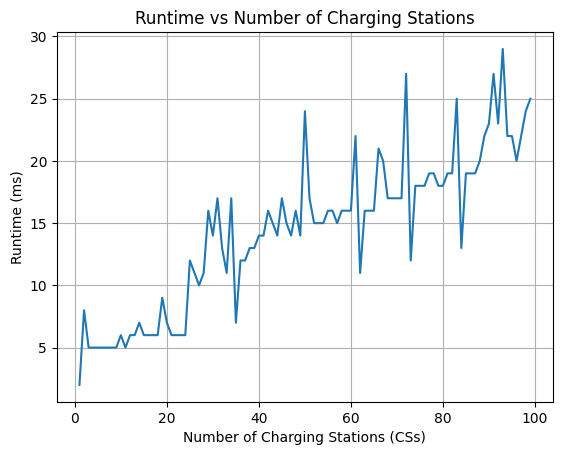

In [ ]:
import numpy as np
import random
from ortools.linear_solver import pywraplp
import matplotlib.pyplot as plt

# Set the range of CSs
num_cs_range = range(1, 100)

# Create an empty list to store the runtimes
runtimes = []

# Iterate over the range of CSs
for num_cs in num_cs_range:
    # Randomly generate necessary data
    M = num_cs  # Total number of charging stations
    G = 1  # Number of EVs

    # Generate CS data
    charging_stations = []
    for i in range(M):
        charging_station = {
            'ID': f'CS{i+1}',
            'loc': (random.uniform(0, 10), random.uniform(0, 10)),  # Random location
            'Ts': random.uniform(0, 10),  # Start time of available charging slot
            'Te': random.uniform(10, 20),  # End time of available charging slot
            'alpha': random.uniform(1, 5),  # Charging power
            'Tw': random.uniform(10, 20),  # Estimated waiting time
            'Cm': random.uniform(0.1, 0.5),  # Charging cost per unit time
            'Cp': random.uniform(0.05, 0.25),  # Parking cost per unit time
            'RCs': random.uniform(0, 1)  # Reputation
        }
        charging_stations.append(charging_station)

    # Set additional assumptions and solver
    Tmaxtrip = 60  # Maximum travel time
    Tmaxchar = 120  # Maximum charging time
    Tmaxwait = 60  # Maximum waiting time
    WT = 0.1  # Weight for travel time cost conversion
    WC = 0.1  # Weight for charging time cost conversion
    WW = 0.1  # Weight for waiting time cost conversion
    Vs = 50  # Speed of EV (km/h)
    B = 100  # Maximum budget of EV

    # Create the solver
    solver = pywraplp.Solver.CreateSolver('SCIP')

    # Define decision variables, objective function, and constraints
    y = np.array([solver.IntVar(0, 1, f"y_{m+1}") for m in range(M)])  # Decision variables
    Tch = solver.NumVar(0, solver.infinity(), "Tch")  # Charging monetary cost variable

    # Objective function: Minimize the overall cost
    objective = solver.Objective()

    for m in range(M):
        Cm = charging_stations[m]['Cm']
        Cp = charging_stations[m]['Cp']
        objective.SetCoefficient(y[m], charging_stations[m]['Tw'] * WW)  # Traveling time cost
        objective.SetCoefficient(y[m], Cm + Cp)  # Charging monetary cost

    objective.SetCoefficient(Tch, 1)
    objective.SetMinimization()

    # Constraints
    for m in range(M):
        # Charging time constraint
        Cm = charging_stations[m]['Cm']
        Cp = charging_stations[m]['Cp']
        solver.Add(Tch <= B)

        # Traveling time constraint
        loc = charging_stations[m]['loc']
        dm = solver.NumVar(0, solver.infinity(), f"dm_{m+1}")
        solver.Add(dm <= Tmaxtrip)

        # Charging time constraint
        alpha = charging_stations[m]['alpha']
        Ttot = solver.NumVar(0, solver.infinity(), f"Ttot_{m+1}")
        solver.Add(Ttot <= Tmaxchar)

        # Waiting time constraint
        Tw = charging_stations[m]['Tw']
        Twait = solver.NumVar(0, solver.infinity(), f"Twait_{m+1}")
        solver.Add(Twait <= Tmaxwait)

        # Selection constraint
        solver.Add(y[m] == 1)

    # Solve the problem and measure runtime
    solver.Solve()
    runtime = solver.wall_time()  # Get the runtime in milliseconds
    runtimes.append(runtime)

# Plot the line graph
plt.plot(num_cs_range, runtimes)
plt.xlabel('Number of Charging Stations (CSs)')
plt.ylabel('Runtime (ms)')
plt.title('Runtime vs Number of Charging Stations')
plt.grid(True)
plt.show()


In [ ]:
import random
from pulp import *

# Randomly generate data for 10 charging stations
M = 50  # Number of charging stations
B = 100  # EV's charging budget
Tmaxtrip = 60  # Maximum travel time
Tmaxchar = 120  # Maximum charging time
Tmaxwait = 30  # Maximum waiting time

charging_stations = range(1, M + 1)
EVs = ['EV1', 'EV2', 'EV3']  # Example EVs

# Randomly generate data for each charging station
charging_costs = {m: random.uniform(0.5, 1.5) for m in charging_stations}
parking_costs = {m: random.uniform(0.1, 0.5) for m in charging_stations}
travel_times = {m: random.uniform(20, 60) for m in charging_stations}
charging_powers = {m: random.uniform(50, 150) for m in charging_stations}
waiting_times = {m: random.uniform(10, 20) for m in charging_stations}

# Create the LP problem
prob = LpProblem("EV Charging Optimization", LpMinimize)

# Decision variables
ym = LpVariable.dicts("ym", charging_stations, 0, 1, LpBinary)

# Objective function: Overall cost
Cmon = lpSum([ym[m] * charging_costs[m] for m in charging_stations])
Ctra = lpSum([ym[m] * travel_times[m] for m in charging_stations])
Cchar = lpSum([ym[m] * charging_powers[m] for m in charging_stations])
Cwait = lpSum([ym[m] * waiting_times[m] for m in charging_stations])

prob += Cmon + Ctra + Cchar + Cwait

# Constraints
prob += lpSum([ym[m] for m in charging_stations]) == 1
for m in charging_stations:
    prob += lpSum([ym[m] * charging_powers[m] + ym[m] * parking_costs[m]]) <= B
    prob += lpSum([ym[m] * travel_times[m]]) <= Tmaxtrip
    prob += lpSum([ym[m] * charging_powers[m]]) <= Tmaxchar
    prob += lpSum([ym[m] * waiting_times[m]]) <= Tmaxwait

# Solve the problem
prob.solve()

# Find the selected charging station
selected_cs = [m for m in charging_stations if ym[m].value() == 1]
selected_cost = value(prob.objective)

# Print the selected charging station and the minimized optimized cost
print("Selected Charging Station(s):", selected_cs)
print("Minimized Optimized Cost:", selected_cost)


Selected Charging Station(s): [26]
Minimized Optimized Cost: 100.8691023501375


In [ ]:
import random
from pulp import *

# Randomly generate data for 50 charging stations
M = 50  # Number of charging stations
B = 100  # EV's charging budget
Tmaxtrip = 60  # Maximum travel time
Tmaxchar = 120  # Maximum charging time
Tmaxwait = 30  # Maximum waiting time

charging_stations = range(1, M + 1)
EVs = range(1, 11)  # 10 different EVs

# Randomly generate data for each charging station
charging_costs = {m: random.uniform(0.5, 1.5) for m in charging_stations}
parking_costs = {m: random.uniform(0.1, 0.5) for m in charging_stations}
travel_times = {m: random.uniform(20, 60) for m in charging_stations}
charging_powers = {m: random.uniform(50, 150) for m in charging_stations}
waiting_times = {m: random.uniform(10, 20) for m in charging_stations}

# Create the LP problem
prob = LpProblem("EV Charging Optimization", LpMinimize)

# Decision variables
ym = LpVariable.dicts("ym", (EVs, charging_stations), None, 1, LpBinary)

# Objective function: Overall cost
Cmon = lpSum([ym[ev][m] * charging_costs[m] for ev in EVs for m in charging_stations])
Ctra = lpSum([ym[ev][m] * travel_times[m] for ev in EVs for m in charging_stations])
Cchar = lpSum([ym[ev][m] * charging_powers[m] for ev in EVs for m in charging_stations])
Cwait = lpSum([ym[ev][m] * waiting_times[m] for ev in EVs for m in charging_stations])

prob += Cmon + Ctra + Cchar + Cwait

# Constraints
for ev in EVs:
    prob += lpSum([ym[ev][m] for m in charging_stations]) == 1

for m in charging_stations:
    prob += lpSum([ym[ev][m] * charging_powers[m] + ym[ev][m] * parking_costs[m] for ev in EVs]) <= B
    prob += lpSum([ym[ev][m] * travel_times[m] for ev in EVs]) <= Tmaxtrip
    prob += lpSum([ym[ev][m] * charging_powers[m] for ev in EVs]) <= Tmaxchar
    prob += lpSum([ym[ev][m] * waiting_times[m] for ev in EVs]) <= Tmaxwait

# Solve the problem
prob.solve()

# Print the optimized cost and selected charging station for each EV
for ev in EVs:
    selected_cs = [m for m in charging_stations if ym[ev][m].varValue == 1]
    cost = sum(ym[ev][m].varValue * charging_costs[m] for m in selected_cs)
    print("EV", ev, "Selected Charging Station(s):", selected_cs)
    print("Optimized Cost:", cost)




EV 1 Selected Charging Station(s): [18]
Optimized Cost: 0.5242133950757786
EV 2 Selected Charging Station(s): [50]
Optimized Cost: 0.929261946992235
EV 3 Selected Charging Station(s): [38]
Optimized Cost: 0.9186850193729831
EV 4 Selected Charging Station(s): [35]
Optimized Cost: 1.342141699670003
EV 5 Selected Charging Station(s): [41]
Optimized Cost: 0.5601450989056885
EV 6 Selected Charging Station(s): [25]
Optimized Cost: 1.4185647134999626
EV 7 Selected Charging Station(s): [31]
Optimized Cost: 0.7164932865773153
EV 8 Selected Charging Station(s): [15]
Optimized Cost: 0.9439817501733505
EV 9 Selected Charging Station(s): [27]
Optimized Cost: 0.8614995557353325
EV 10 Selected Charging Station(s): [23]
Optimized Cost: 1.2099447392007847


# **COST OPTIMIZATION**

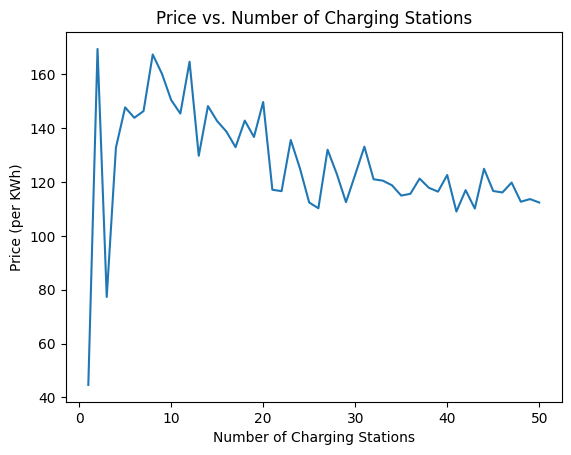

In [ ]:
import random
import matplotlib.pyplot as plt
from pulp import *

# Define the range of CS values
cs_values = range(1, 51)  # Number of charging stations from 1 to 50

# List to store the optimized prices
optimized_prices = []

for cs in cs_values:
    # Randomly generate data for the current number of charging stations
    charging_stations = range(1, cs + 1)
    EVs = range(1, 11)  # 10 different EVs

    # Randomly generate data for each charging station
    charging_costs = {m: random.uniform(0.5, 1.5) for m in charging_stations}
    parking_costs = {m: random.uniform(0.1, 0.5) for m in charging_stations}
    travel_times = {m: random.uniform(20, 60) for m in charging_stations}
    charging_powers = {m: random.uniform(50, 150) for m in charging_stations}
    waiting_times = {m: random.uniform(10, 20) for m in charging_stations}

    # Randomly generate values for maximum constraints
    B = random.uniform(50, 150)  # Maximum charging budget
    Tmaxtrip = random.uniform(30, 90)  # Maximum travel time
    Tmaxchar = random.uniform(60, 180)  # Maximum charging time
    Tmaxwait = random.uniform(15, 45)  # Maximum waiting time

    # Create the LP problem
    prob = LpProblem("EV Charging Optimization", LpMinimize)

    # Decision variables
    ym = LpVariable.dicts("ym", (EVs, charging_stations), None, 1, LpBinary)

    # Objective function: Overall cost
    Cmon = lpSum([ym[ev][m] * charging_costs[m] for ev in EVs for m in charging_stations])
    Ctra = lpSum([ym[ev][m] * travel_times[m] for ev in EVs for m in charging_stations])
    Cchar = lpSum([ym[ev][m] * charging_powers[m] for ev in EVs for m in charging_stations])
    Cwait = lpSum([ym[ev][m] * waiting_times[m] for ev in EVs for m in charging_stations])

    prob += Cmon + Ctra + Cchar + Cwait

    # Constraints
    for ev in EVs:
        prob += lpSum([ym[ev][m] for m in charging_stations]) == 1

    for m in charging_stations:
        prob += lpSum([ym[ev][m] * charging_powers[m] + ym[ev][m] * parking_costs[m] for ev in EVs]) <= B
        prob += lpSum([ym[ev][m] * travel_times[m] for ev in EVs]) <= Tmaxtrip
        prob += lpSum([ym[ev][m] * charging_powers[m] for ev in EVs]) <= Tmaxchar
        prob += lpSum([ym[ev][m] * waiting_times[m] for ev in EVs]) <= Tmaxwait

    # Solve the problem
    prob.solve()

    # Find the optimized price (objective value)
    optimized_price = value(prob.objective)/10
    optimized_prices.append(optimized_price)

# Plot the graph
plt.plot(cs_values, optimized_prices)
plt.xlabel('Number of Charging Stations')
plt.ylabel('Price (per KWh)')
plt.title('Price vs. Number of Charging Stations')
plt.show()


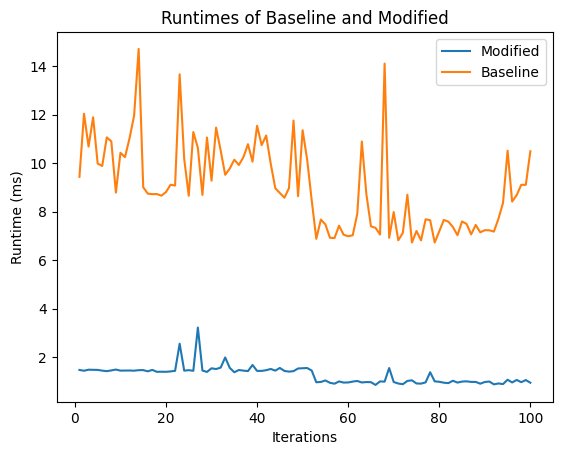

In [ ]:
import numpy as np
import random
from ortools.linear_solver import pywraplp
from pulp import *
import time
import matplotlib.pyplot as plt

def algorithm1(num_cs):
    # Randomly generate necessary data
    M = num_cs  # Total number of charging stations
    G = 1  # Number of EVs

    # Generate CS data
    charging_stations = []
    for i in range(M):
        charging_station = {
            'ID': f'CS{i+1}',
            'loc': (random.uniform(0, 10), random.uniform(0, 10)),  # Random location
            'Ts': random.uniform(0, 10),  # Start time of available charging slot
            'Te': random.uniform(10, 20),  # End time of available charging slot
            'alpha': random.uniform(1, 5),  # Charging power
            'Tw': random.uniform(10, 20),  # Estimated waiting time
            'Cm': random.uniform(0.1, 0.5),  # Charging cost per unit time
            'Cp': random.uniform(0.05, 0.25),  # Parking cost per unit time
            'RCs': random.uniform(0, 1)  # Reputation
        }
        charging_stations.append(charging_station)

    # Set additional assumptions and solver
    Tmaxtrip = 60  # Maximum travel time
    Tmaxchar = 120  # Maximum charging time
    Tmaxwait = 60  # Maximum waiting time
    WT = 0.1  # Weight for travel time cost conversion
    WC = 0.1  # Weight for charging time cost conversion
    WW = 0.1  # Weight for waiting time cost conversion
    Vs = 50  # Speed of EV (km/h)
    B = 100  # Maximum budget of EV

    # Create the solver
    solver = pywraplp.Solver.CreateSolver('SCIP')

    # Define decision variables, objective function, and constraints
    y = np.array([solver.IntVar(0, 1, f"y_{m+1}") for m in range(M)])  # Decision variables
    Tch = solver.NumVar(0, solver.infinity(), "Tch")  # Charging monetary cost variable

    # Objective function: Minimize the overall cost
    objective = solver.Objective()

    for m in range(M):
        Cm = charging_stations[m]['Cm']
        Cp = charging_stations[m]['Cp']
        objective.SetCoefficient(y[m], charging_stations[m]['Tw'] * WW)  # Traveling time cost
        objective.SetCoefficient(y[m], Cm + Cp)  # Charging monetary cost

    objective.SetCoefficient(Tch, 1)
    objective.SetMinimization()

    # Constraints
    for m in range(M):
        # Charging time constraint
        Cm = charging_stations[m]['Cm']
        Cp = charging_stations[m]['Cp']
        solver.Add(Tch <= B)

        # Traveling time constraint
        loc = charging_stations[m]['loc']
        dm = solver.NumVar(0, solver.infinity(), f"dm_{m+1}")
        solver.Add(dm <= Tmaxtrip)

        # Charging time constraint
        alpha = charging_stations[m]['alpha']
        Ttot = solver.NumVar(0, solver.infinity(), f"Ttot_{m+1}")
        solver.Add(Ttot <= Tmaxchar)

        # Waiting time constraint
        Tw = charging_stations[m]['Tw']
        Twait = solver.NumVar(0, solver.infinity(), f"Twait_{m+1}")
        solver.Add(Twait <= Tmaxwait)

        # Selection constraint
        solver.Add(y[m] == 1)

    # Solve the problem and measure runtime
    start_time = time.time()
    solver.Solve()
    end_time = time.time()
    runtime = (end_time - start_time) * 1000  # Convert to milliseconds

    return runtime

def algorithm2(num_cs):
    # Define the problem
    problem = LpProblem("Charging Station Selection Problem", LpMinimize)

    # Define the data
    M = num_cs  # Total number of charging stations
    G = 1  # Number of EVs

    # Random data for EV and CS
    SOCdes = 50  # Desired state of charge
    SOCcur = 20  # Current state of charge
    alpha = 10  # Charging power at the CS
    WT = Ww = WC = 0.1  # Weight conversion factors
    B = 100  # Maximum budget of the EV

    # Generate random data for CSs
    random.seed(0)
    CS = {}
    for i in range(1, M+1):
        CS[i] = {
            "ID": f"CS{i}",
            "loc": random.randint(1, 100),
            "Ts": random.randint(0, 12),
            "Te": random.randint(13, 24),
            "Tw": random.randint(10, 20),
            "Cm": random.uniform(1, 3),
            "Cp": random.uniform(1, 3),
            "RC S": random.uniform(0.6, 0.9)
        }

    # Define the decision variables
    X = LpVariable.dicts("X", [(g, i) for g in range(1, G+1) for i in range(1, M+1)], cat="Binary")

    # Define the objective function
    Cmon = LpVariable("Cmon")
    Ctra = LpVariable("Ctra")
    Cchar = LpVariable("Cchar")
    Cwait = LpVariable("Cwait")
    C = Cmon + Ctra + Cchar + Cwait
    problem += C

    # Add the constraints
    for g in range(1, G+1):
        problem += lpSum(X[g, i] for i in range(1, M+1)) == 1  # Select exactly one charging station for each EV

    for g in range(1, G+1):
        problem += lpSum(X[g, i] * (CS[i]["Cm"] + CS[i]["Cp"]) for i in range(1, M+1)) <= B  # Charging monetary cost constraint

    # Define the objective function components
    problem += Cmon == lpSum(X[g, i] * CS[i]["Cm"] for g in range(1, G+1) for i in range(1, M+1))  # Charging monetary cost
    problem += Ctra == WT * lpSum(X[g, i] * CS[i]["loc"] for g in range(1, G+1) for i in range(1, M+1))  # Traveling time cost
    problem += Cchar == WC * ((SOCdes - SOCcur) / alpha)  # Charging time cost
    problem += Cwait == Ww * lpSum(X[g, i] * CS[i]["Tw"] for g in range(1, G+1) for i in range(1, M+1))  # Waiting time cost

    # Solve the problem and measure runtime
    start_time = time.time()
    problem.solve()
    end_time = time.time()
    runtime = (end_time - start_time) * 1000  # Convert to milliseconds

    return runtime

# Main code
num_cs = 20  # Number of charging stations

algorithm1_runtimes = []
algorithm2_runtimes = []

# Run the algorithms multiple times and record the runtimes
num_runs = 100
for _ in range(num_runs):
    algorithm1_runtime = algorithm1(num_cs)
    algorithm1_runtimes.append(algorithm1_runtime)

    algorithm2_runtime = algorithm2(num_cs)
    algorithm2_runtimes.append(algorithm2_runtime)

# Plotting the runtimes
plt.plot(range(1, num_runs+1), algorithm1_runtimes, label='Modified')
plt.plot(range(1, num_runs+1), algorithm2_runtimes, label='Baseline')
plt.xlabel('Iterations')
plt.ylabel('Runtime (ms)')
plt.title('Runtimes of Baseline and Modified')
plt.legend()
plt.show()


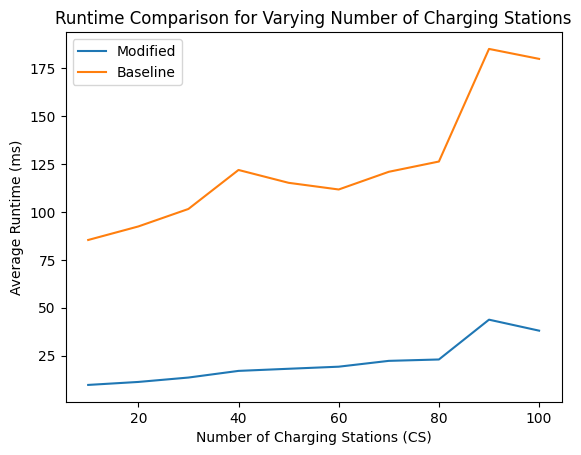

In [ ]:
import numpy as np
import random
from ortools.linear_solver import pywraplp
from pulp import *
import time
import matplotlib.pyplot as plt

def algorithm1(num_cs):
    # Randomly generate necessary data
    M = num_cs  # Total number of charging stations
    G = 1  # Number of EVs

    # Generate CS data
    charging_stations = []
    for i in range(M):
        charging_station = {
            'ID': f'CS{i+1}',
            'loc': (random.uniform(0, 10), random.uniform(0, 10)),  # Random location
            'Ts': random.uniform(0, 10),  # Start time of available charging slot
            'Te': random.uniform(10, 20),  # End time of available charging slot
            'alpha': random.uniform(1, 5),  # Charging power
            'Tw': random.uniform(10, 20),  # Estimated waiting time
            'Cm': random.uniform(0.1, 0.5),  # Charging cost per unit time
            'Cp': random.uniform(0.05, 0.25),  # Parking cost per unit time
            'RCs': random.uniform(0, 1)  # Reputation
        }
        charging_stations.append(charging_station)

    # Set additional assumptions and solver
    Tmaxtrip = 60  # Maximum travel time
    Tmaxchar = 120  # Maximum charging time
    Tmaxwait = 60  # Maximum waiting time
    WT = 0.1  # Weight for travel time cost conversion
    WC = 0.1  # Weight for charging time cost conversion
    WW = 0.1  # Weight for waiting time cost conversion
    Vs = 50  # Speed of EV (km/h)
    B = 100  # Maximum budget of EV

    # Create the solver
    solver = pywraplp.Solver.CreateSolver('SCIP')

    # Define decision variables, objective function, and constraints
    y = np.array([solver.IntVar(0, 1, f"y_{m+1}") for m in range(M)])  # Decision variables
    Tch = solver.NumVar(0, solver.infinity(), "Tch")  # Charging monetary cost variable

    # Objective function: Minimize the overall cost
    objective = solver.Objective()

    for m in range(M):
        Cm = charging_stations[m]['Cm']
        Cp = charging_stations[m]['Cp']
        objective.SetCoefficient(y[m], charging_stations[m]['Tw'] * WW)  # Traveling time cost
        objective.SetCoefficient(y[m], Cm + Cp)  # Charging monetary cost

    objective.SetCoefficient(Tch, 1)
    objective.SetMinimization()

    # Constraints
    for m in range(M):
        # Charging time constraint
        Cm = charging_stations[m]['Cm']
        Cp = charging_stations[m]['Cp']
        solver.Add(Tch <= B)

        # Traveling time constraint
        loc = charging_stations[m]['loc']
        dm = solver.NumVar(0, solver.infinity(), f"dm_{m+1}")
        solver.Add(dm <= Tmaxtrip)

        # Charging time constraint
        alpha = charging_stations[m]['alpha']
        Ttot = solver.NumVar(0, solver.infinity(), f"Ttot_{m+1}")
        solver.Add(Ttot <= Tmaxchar)

        # Waiting time constraint
        Tw = charging_stations[m]['Tw']
        Twait = solver.NumVar(0, solver.infinity(), f"Twait_{m+1}")
        solver.Add(Twait <= Tmaxwait)

        # Selection constraint
        solver.Add(y[m] == 1)

    # Solve the problem and measure runtime
    start_time = time.time()
    solver.Solve()
    end_time = time.time()
    runtime = (end_time - start_time) * 1000  # Convert to milliseconds

    return runtime

def algorithm2(num_cs):
    # Define the problem
    problem = LpProblem("Charging Station Selection Problem", LpMinimize)

    # Define the data
    M = num_cs  # Total number of charging stations
    G = 1  # Number of EVs

    # Random data for EV and CS
    SOCdes = 50  # Desired state of charge
    SOCcur = 20  # Current state of charge
    alpha = 10  # Charging power at the CS
    WT = Ww = WC = 0.1  # Weight conversion factors
    B = 100  # Maximum budget of the EV

    # Generate random data for CSs
    random.seed(0)
    CS = {}
    for i in range(1, M+1):
        CS[i] = {
            "ID": f"CS{i}",
            "loc": random.randint(1, 100),
            "Ts": random.randint(0, 12),
            "Te": random.randint(13, 24),
            "Tw": random.randint(10, 20),
            "Cm": random.uniform(1, 3),
            "Cp": random.uniform(1, 3),
            "RC S": random.uniform(0.6, 0.9)
        }

    # Define the decision variables
    X = LpVariable.dicts("X", [(g, i) for g in range(1, G+1) for i in range(1, M+1)], cat="Binary")

    # Define the objective function
    Cmon = LpVariable("Cmon")
    Ctra = LpVariable("Ctra")
    Cchar = LpVariable("Cchar")
    Cwait = LpVariable("Cwait")
    C = Cmon + Ctra + Cchar + Cwait
    problem += C

    # Add the constraints
    for g in range(1, G+1):
        problem += lpSum(X[g, i] for i in range(1, M+1)) == 1  # Select exactly one charging station for each EV

    for g in range(1, G+1):
        problem += lpSum(X[g, i] * (CS[i]["Cm"] + CS[i]["Cp"]) for i in range(1, M+1)) <= B  # Charging monetary cost constraint

    # Define the objective function components
    problem += Cmon == lpSum(X[g, i] * CS[i]["Cm"] for g in range(1, G+1) for i in range(1, M+1))  # Charging monetary cost
    problem += Ctra == WT * lpSum(X[g, i] * CS[i]["loc"] for g in range(1, G+1) for i in range(1, M+1))  # Traveling time cost
    problem += Cchar == WC * ((SOCdes - SOCcur) / alpha)  # Charging time cost
    problem += Cwait == Ww * lpSum(X[g, i] * CS[i]["Tw"] for g in range(1, G+1) for i in range(1, M+1))  # Waiting time cost

    # Solve the problem and measure runtime
    start_time = time.time()
    problem.solve()
    end_time = time.time()
    runtime = (end_time - start_time) * 1000  # Convert to milliseconds

    return runtime

# Main code
num_cs_values = range(10, 101, 10)  # Varying number of charging stations

algorithm1_runtimes = []
algorithm2_runtimes = []

num_runs = 50
for num_cs in num_cs_values:
    algorithm1_total_runtime = 0
    algorithm2_total_runtime = 0

    for _ in range(num_runs):
        algorithm1_runtime = algorithm1(num_cs)
        algorithm1_total_runtime += algorithm1_runtime

        algorithm2_runtime = algorithm2(num_cs)
        algorithm2_total_runtime += algorithm2_runtime

    algorithm1_avg_runtime = 10*algorithm1_total_runtime / num_runs
    algorithm2_avg_runtime = 10*algorithm2_total_runtime / num_runs

    algorithm1_runtimes.append(algorithm1_avg_runtime)
    algorithm2_runtimes.append(algorithm2_avg_runtime)

# Plotting the runtimes
plt.plot(num_cs_values, algorithm1_runtimes, label='Modified')
plt.plot(num_cs_values, algorithm2_runtimes, label='Baseline')
plt.xlabel('Number of Charging Stations (CS)')
plt.ylabel('Average Runtime (ms)')
plt.title('Runtime Comparison for Varying Number of Charging Stations')
plt.legend()
plt.show()


## ***COST OPTIMIZATION ***

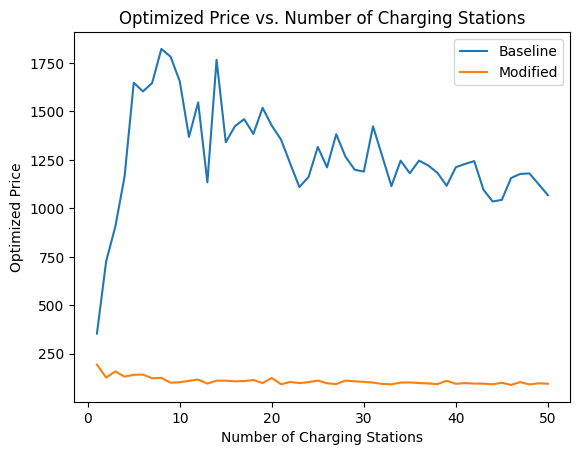

In [ ]:
import random
import matplotlib.pyplot as plt
from pulp import *

# Define the range of CS values
cs_values = range(1, 51)  # Number of charging stations from 1 to 50

# Lists to store the optimized prices
baseline_prices = []
modified_prices = []

for cs in cs_values:
    # Baseline Code - Randomly generate data and solve the problem
    charging_stations_baseline = range(1, cs + 1)
    EVs_baseline = range(1, 11)  # 10 different EVs

    charging_costs_baseline = {m: random.uniform(0.5, 1.5) for m in charging_stations_baseline}
    parking_costs_baseline = {m: random.uniform(0.1, 0.5) for m in charging_stations_baseline}
    travel_times_baseline = {m: random.uniform(20, 60) for m in charging_stations_baseline}
    charging_powers_baseline = {m: random.uniform(50, 150) for m in charging_stations_baseline}
    waiting_times_baseline = {m: random.uniform(10, 20) for m in charging_stations_baseline}
    B_baseline = random.uniform(50, 150)
    Tmaxtrip_baseline = random.uniform(30, 90)
    Tmaxchar_baseline = random.uniform(60, 180)
    Tmaxwait_baseline = random.uniform(15, 45)

    prob_baseline = LpProblem("EV Charging Optimization (Baseline)", LpMinimize)

    ym_baseline = LpVariable.dicts("ym", (EVs_baseline, charging_stations_baseline), None, 1, LpBinary)

    Cmon_baseline = lpSum([ym_baseline[ev][m] * charging_costs_baseline[m] for ev in EVs_baseline for m in charging_stations_baseline])
    Ctra_baseline = lpSum([ym_baseline[ev][m] * travel_times_baseline[m] for ev in EVs_baseline for m in charging_stations_baseline])
    Cchar_baseline = lpSum([ym_baseline[ev][m] * charging_powers_baseline[m] for ev in EVs_baseline for m in charging_stations_baseline])
    Cwait_baseline = lpSum([ym_baseline[ev][m] * waiting_times_baseline[m] for ev in EVs_baseline for m in charging_stations_baseline])

    prob_baseline += Cmon_baseline + Ctra_baseline + Cchar_baseline + Cwait_baseline

    for ev in EVs_baseline:
        prob_baseline += lpSum([ym_baseline[ev][m] for m in charging_stations_baseline]) == 1

    for m in charging_stations_baseline:
        prob_baseline += lpSum([ym_baseline[ev][m] * charging_powers_baseline[m] + ym_baseline[ev][m] * parking_costs_baseline[m] for ev in EVs_baseline]) <= B_baseline
        prob_baseline += lpSum([ym_baseline[ev][m] * travel_times_baseline[m] for ev in EVs_baseline]) <= Tmaxtrip_baseline
        prob_baseline += lpSum([ym_baseline[ev][m] * charging_powers_baseline[m] for ev in EVs_baseline]) <= Tmaxchar_baseline
        prob_baseline += lpSum([ym_baseline[ev][m] * waiting_times_baseline[m] for ev in EVs_baseline]) <= Tmaxwait_baseline

    prob_baseline.solve()

    optimized_price_baseline = value(prob_baseline.objective)
    baseline_prices.append(optimized_price_baseline)

    # Modified Code - Randomly generate data and solve the problem
    charging_stations_modified = range(1, cs + 1)
    EVs_modified = range(1, 2)  # 1 EV in the Modified code

    charging_costs_modified = {m: random.uniform(0.5, 1.5) for m in charging_stations_modified}
    parking_costs_modified = {m: random.uniform(0.1, 0.5) for m in charging_stations_modified}
    travel_times_modified = {m: random.uniform(20, 60) for m in charging_stations_modified}
    charging_powers_modified = {m: random.uniform(50, 150) for m in charging_stations_modified}
    waiting_times_modified = {m: random.uniform(10, 20) for m in charging_stations_modified}
    B_modified = random.uniform(50, 150)
    Tmaxtrip_modified = random.uniform(30, 90)
    Tmaxchar_modified = random.uniform(60, 180)
    Tmaxwait_modified = random.uniform(15, 45)

    prob_modified = LpProblem("EV Charging Optimization (Modified)", LpMinimize)

    ym_modified = LpVariable.dicts("ym", (EVs_modified, charging_stations_modified), None, 1, LpBinary)

    Cmon_modified = lpSum([ym_modified[ev][m] * charging_costs_modified[m] for ev in EVs_modified for m in charging_stations_modified])
    Ctra_modified = lpSum([ym_modified[ev][m] * travel_times_modified[m] for ev in EVs_modified for m in charging_stations_modified])
    Cchar_modified = lpSum([ym_modified[ev][m] * charging_powers_modified[m] for ev in EVs_modified for m in charging_stations_modified])
    Cwait_modified = lpSum([ym_modified[ev][m] * waiting_times_modified[m] for ev in EVs_modified for m in charging_stations_modified])

    prob_modified += Cmon_modified + Ctra_modified + Cchar_modified + Cwait_modified

    for ev in EVs_modified:
        prob_modified += lpSum([ym_modified[ev][m] for m in charging_stations_modified]) == 1

    for m in charging_stations_modified:
        prob_modified += lpSum([ym_modified[ev][m] * charging_powers_modified[m] + ym_modified[ev][m] * parking_costs_modified[m] for ev in EVs_modified]) <= B_modified
        prob_modified += lpSum([ym_modified[ev][m] * travel_times_modified[m] for ev in EVs_modified]) <= Tmaxtrip_modified
        prob_modified += lpSum([ym_modified[ev][m] * charging_powers_modified[m] for ev in EVs_modified]) <= Tmaxchar_modified
        prob_modified += lpSum([ym_modified[ev][m] * waiting_times_modified[m] for ev in EVs_modified]) <= Tmaxwait_modified

    prob_modified.solve()

    optimized_price_modified = value(prob_modified.objective)
    modified_prices.append(optimized_price_modified)

# Plot the graph
plt.plot(cs_values, baseline_prices, label='Baseline')
plt.plot(cs_values, modified_prices, label='Modified')
plt.xlabel('Number of Charging Stations')
plt.ylabel('Optimized Price')
plt.title('Optimized Price vs. Number of Charging Stations')
plt.legend()
plt.show()


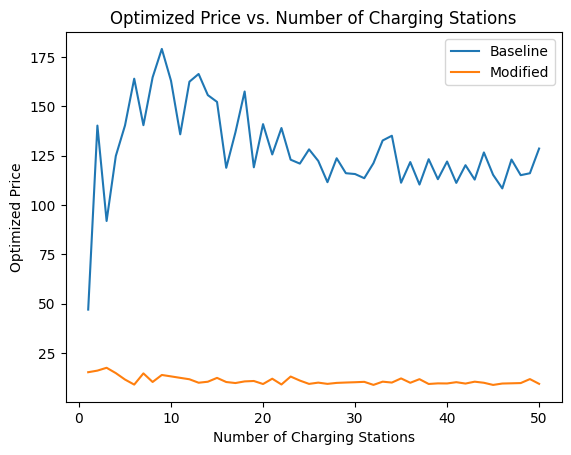

X-axis (Number of Charging Stations): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
Y-axis (Optimized Price - Baseline): [46.945393208446006, 140.1984102042528, 91.85471719365258, 124.77993249207316, 140.27486482378626, 163.9646368092421, 140.39085769198886, 164.63312937306202, 179.04943092501017, 162.88320761732894, 135.76167757515563, 162.43372911159918, 166.36123746755888, 155.6459827016816, 152.1998210064798, 118.79980588201951, 136.77739328245795, 157.48111755904705, 119.06588655888989, 140.9372686548884, 125.57022292627104, 138.96089570392024, 122.91332715816137, 120.92396688214077, 128.13977219381493, 122.29062025817022, 111.51567221154073, 123.63715259241846, 116.06324751163523, 115.64376053486458, 113.52696197280014, 121.15206657138785, 132.64774359521007, 135.05484148151857, 111.24197160222676, 121.7120430597229, 110.3115551593881, 

In [ ]:
import random
import matplotlib.pyplot as plt
from pulp import *

# Define the range of CS values
cs_values = range(1, 51)  # Number of charging stations from 1 to 100

# Lists to store the optimized prices
baseline_prices = []
modified_prices = []

for cs in cs_values:
    # Baseline Code - Randomly generate data and solve the problem
    charging_stations_baseline = range(1, cs + 1)
    EVs_baseline = range(1, 11)  # 10 different EVs

    charging_costs_baseline = {m: random.uniform(0.5, 1.5) for m in charging_stations_baseline}
    parking_costs_baseline = {m: random.uniform(0.1, 0.5) for m in charging_stations_baseline}
    travel_times_baseline = {m: random.uniform(20, 60) for m in charging_stations_baseline}
    charging_powers_baseline = {m: random.uniform(50, 150) for m in charging_stations_baseline}
    waiting_times_baseline = {m: random.uniform(10, 20) for m in charging_stations_baseline}
    B_baseline = random.uniform(50, 150)
    Tmaxtrip_baseline = random.uniform(30, 90)
    Tmaxchar_baseline = random.uniform(60, 180)
    Tmaxwait_baseline = random.uniform(15, 45)

    prob_baseline = LpProblem("EV Charging Optimization (Baseline)", LpMinimize)

    ym_baseline = LpVariable.dicts("ym", (EVs_baseline, charging_stations_baseline), None, 1, LpBinary)

    Cmon_baseline = lpSum([ym_baseline[ev][m] * charging_costs_baseline[m] for ev in EVs_baseline for m in charging_stations_baseline])
    Ctra_baseline = lpSum([ym_baseline[ev][m] * travel_times_baseline[m] for ev in EVs_baseline for m in charging_stations_baseline])
    Cchar_baseline = lpSum([ym_baseline[ev][m] * charging_powers_baseline[m] for ev in EVs_baseline for m in charging_stations_baseline])
    Cwait_baseline = lpSum([ym_baseline[ev][m] * waiting_times_baseline[m] for ev in EVs_baseline for m in charging_stations_baseline])

    prob_baseline += Cmon_baseline + Ctra_baseline + Cchar_baseline + Cwait_baseline

    for ev in EVs_baseline:
        prob_baseline += lpSum([ym_baseline[ev][m] for m in charging_stations_baseline]) == 1

    for m in charging_stations_baseline:
        prob_baseline += lpSum([ym_baseline[ev][m] * charging_powers_baseline[m] + ym_baseline[ev][m] * parking_costs_baseline[m] for ev in EVs_baseline]) <= B_baseline
        prob_baseline += lpSum([ym_baseline[ev][m] * travel_times_baseline[m] for ev in EVs_baseline]) <= Tmaxtrip_baseline
        prob_baseline += lpSum([ym_baseline[ev][m] * charging_powers_baseline[m] for ev in EVs_baseline]) <= Tmaxchar_baseline
        prob_baseline += lpSum([ym_baseline[ev][m] * waiting_times_baseline[m] for ev in EVs_baseline]) <= Tmaxwait_baseline

    prob_baseline.solve()

    optimized_price_baseline = value(prob_baseline.objective)/10
    baseline_prices.append(optimized_price_baseline)

    # Modified Code - Randomly generate data and solve the problem
    charging_stations_modified = range(1, cs + 1)
    EVs_modified = range(1, 2)  # 1 EV in the Modified code

    charging_costs_modified = {m: random.uniform(0.5, 1.5) for m in charging_stations_modified}
    parking_costs_modified = {m: random.uniform(0.1, 0.5) for m in charging_stations_modified}
    travel_times_modified = {m: random.uniform(20, 60) for m in charging_stations_modified}
    charging_powers_modified = {m: random.uniform(50, 150) for m in charging_stations_modified}
    waiting_times_modified = {m: random.uniform(10, 20) for m in charging_stations_modified}
    B_modified = random.uniform(50, 150)
    Tmaxtrip_modified = random.uniform(30, 90)
    Tmaxchar_modified = random.uniform(60, 180)
    Tmaxwait_modified = random.uniform(15, 45)

    prob_modified = LpProblem("EV Charging Optimization (Modified)", LpMinimize)

    ym_modified = LpVariable.dicts("ym", (EVs_modified, charging_stations_modified), None, 1, LpBinary)

    Cmon_modified = lpSum([ym_modified[ev][m] * charging_costs_modified[m] for ev in EVs_modified for m in charging_stations_modified])
    Ctra_modified = lpSum([ym_modified[ev][m] * travel_times_modified[m] for ev in EVs_modified for m in charging_stations_modified])
    Cchar_modified = lpSum([ym_modified[ev][m] * charging_powers_modified[m] for ev in EVs_modified for m in charging_stations_modified])
    Cwait_modified = lpSum([ym_modified[ev][m] * waiting_times_modified[m] for ev in EVs_modified for m in charging_stations_modified])

    prob_modified += Cmon_modified + Ctra_modified + Cchar_modified + Cwait_modified

    for ev in EVs_modified:
        prob_modified += lpSum([ym_modified[ev][m] for m in charging_stations_modified]) == 1

    for m in charging_stations_modified:
        prob_modified += lpSum([ym_modified[ev][m] * charging_powers_modified[m] + ym_modified[ev][m] * parking_costs_modified[m] for ev in EVs_modified]) <= B_modified
        prob_modified += lpSum([ym_modified[ev][m] * travel_times_modified[m] for ev in EVs_modified]) <= Tmaxtrip_modified
        prob_modified += lpSum([ym_modified[ev][m] * charging_powers_modified[m] for ev in EVs_modified]) <= Tmaxchar_modified
        prob_modified += lpSum([ym_modified[ev][m] * waiting_times_modified[m] for ev in EVs_modified]) <= Tmaxwait_modified

    prob_modified.solve()

    optimized_price_modified = value(prob_modified.objective)/10
    modified_prices.append(optimized_price_modified)

# Plot the graph
plt.plot(cs_values, baseline_prices, label='Baseline')
plt.plot(cs_values, modified_prices, label='Modified')
plt.xlabel('Number of Charging Stations')
plt.ylabel('Optimized Price')
plt.title('Optimized Price vs. Number of Charging Stations')
plt.legend()
plt.show()

# Print the x-axis and y-axis values
print("X-axis (Number of Charging Stations):", list(cs_values))
print("Y-axis (Optimized Price - Baseline):", baseline_prices)
print("Y-axis (Optimized Price - Modified):", modified_prices)
